In [1]:
# %pip install pandas numpy matplotlib spacy scikit-learn
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
%pip install https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.4.0/ru_core_news_sm-3.4.0-py3-none-any.whl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

2023-01-17 01:03:46.866406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 01:03:47.082338: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-17 01:03:47.181105: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-17 01:03:47.838731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
data = pd.read_csv("../data/pre_filtered_data.csv", lineterminator='\n', index_col=False)
data.head()

,review,target
0,3D Touch просто восхитительная вещь! Заряд дер...,1
1,"В Apple окончательно решили не заморачиваться,...",0
2,Постарался наиболее ёмко и коротко описать все...,1
3,Достойный телефон. Пользоваться одно удовольст...,1
4,6s gold 64gb,1


In [4]:
data.shape

(127567, 2)

## Предобработка данных

In [5]:
train_data, test_data = train_test_split(data, test_size=0.1, shuffle=True, random_state=42)
train_data = train_data.reset_index()[['review', 'target']]
test_data = test_data.reset_index()[['review', 'target']]
print(train_data.shape)
print(test_data.shape)
train_data.head()

(114810, 2)
(12757, 2)


,review,target
0,Ну что могу сказать.. Взял по предзаказу в инт...,1
1,приобретался менее года назад. спустя нескольк...,0
2,Пользуюсь около 8 месяцев.,1
3,"Хорошо выглядит, устойчивая работа, хорошая св...",1
4,Телефон очень хороший это была моя первая ноки...,1


In [6]:
class Preprocessor:
    def __init__(self):
        self._nlp = spacy.load("ru_core_news_sm")
    def preprocess_text(self, text):
            doc = self._nlp(str(text))
            for token in doc:
                if token.is_stop or token.is_punct or token.like_num or token.like_url \
                or token.like_email or token.is_digit or len(token) <= 1 or token.is_space \
                or not re.match(r'^[a-zA-Zа-яА-Я]+$', str(token)):
                    continue
                yield token.lemma_

preprocessor = Preprocessor()
                
X_train = train_data.review.map(lambda x: " ".join(preprocessor.preprocess_text(x)))
y_train = train_data.target
X_test = test_data.review.map(lambda x: " ".join(preprocessor.preprocess_text(x)))
y_test = test_data.target

KeyboardInterrupt: 

In [6]:
X_train.head()

0    убитый время продавать покупать андроид ценовы...
1    пользоваться самсунгами note sony compact lg р...
2         знать отзыв сказать аудио выход тк отвратный
3    целое аппарат отличный смело рекомендовать пок...
4    достаточный gb хороший посмотреть сторона быст...
Name: review, dtype: object

## Графики

Text(0, 0.5, 'Количество записей')

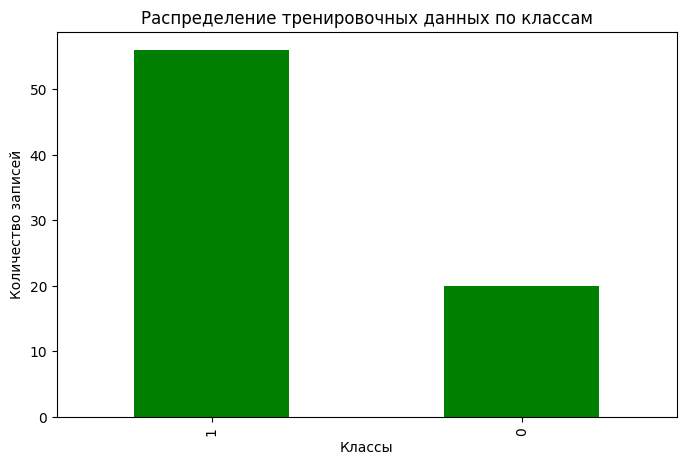

In [7]:
plt.figure(figsize=(8,5))
y_train.value_counts().plot(kind='bar',color='green')
plt.title('Распределение тренировочных данных по классам')
plt.xlabel('Классы')
plt.ylabel('Количество записей')

Text(0, 0.5, 'Количество записей')

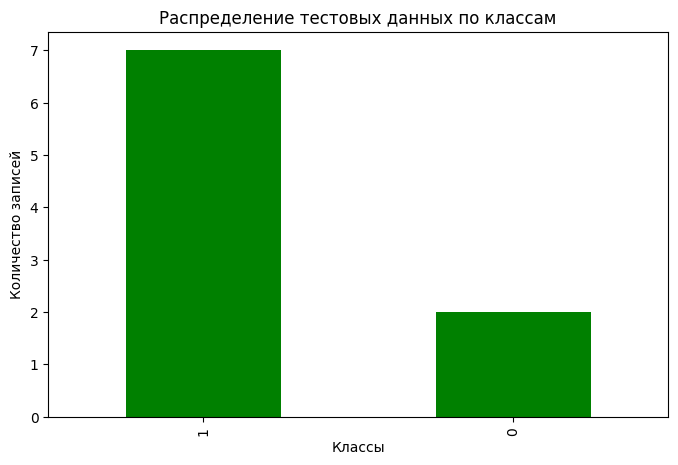

In [8]:
plt.figure(figsize=(8,5))
y_test.value_counts().plot(kind='bar',color='green')
plt.title('Распределение тестовых данных по классам')
plt.xlabel('Классы')
plt.ylabel('Количество записей')

Text(0, 0.5, 'Количество твитов')

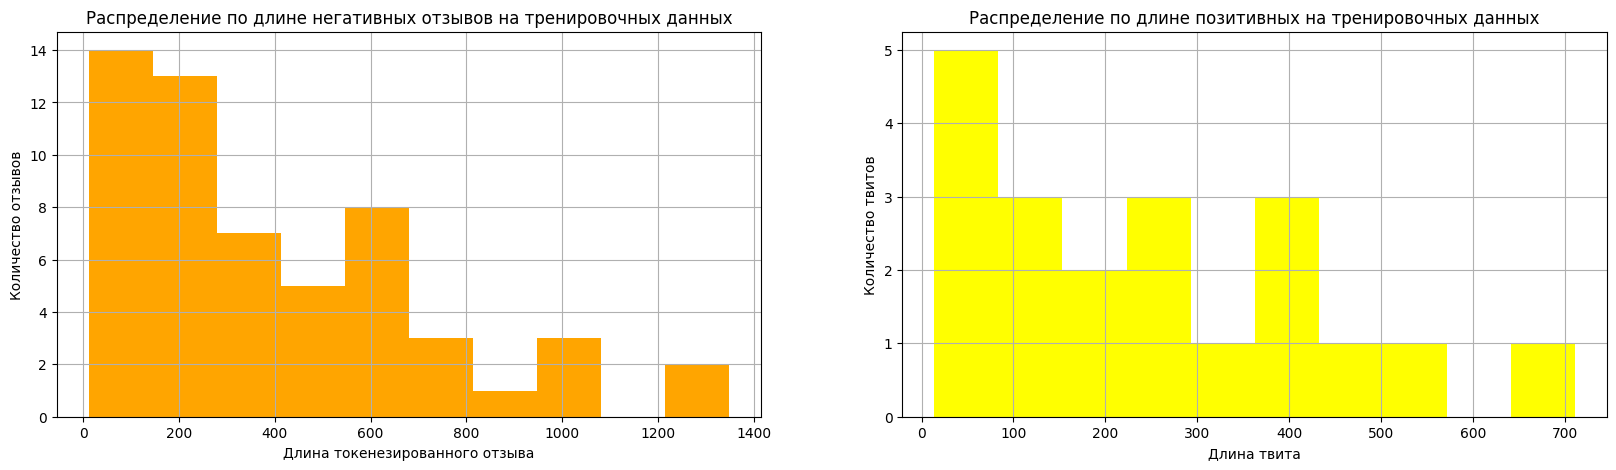

In [9]:
len_negatives = X_train[y_train == 1].str.len()
len_positives = X_train[y_train == 0].str.len()

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(len_negatives,color='orange')
plt.grid()
plt.title('Распределение по длине негативных отзывов на тренировочных данных')
plt.xlabel('Длина токенезированного отзыва')
plt.ylabel('Количество отзывов')
plt.subplot(1,2,2)
plt.hist(len_positives,color='yellow',)
plt.grid()
plt.title('Распределение по длине позитивных на тренировочных данных')
plt.xlabel('Длина твита')
plt.ylabel('Количество твитов')

Text(0, 0.5, 'Количество твитов')

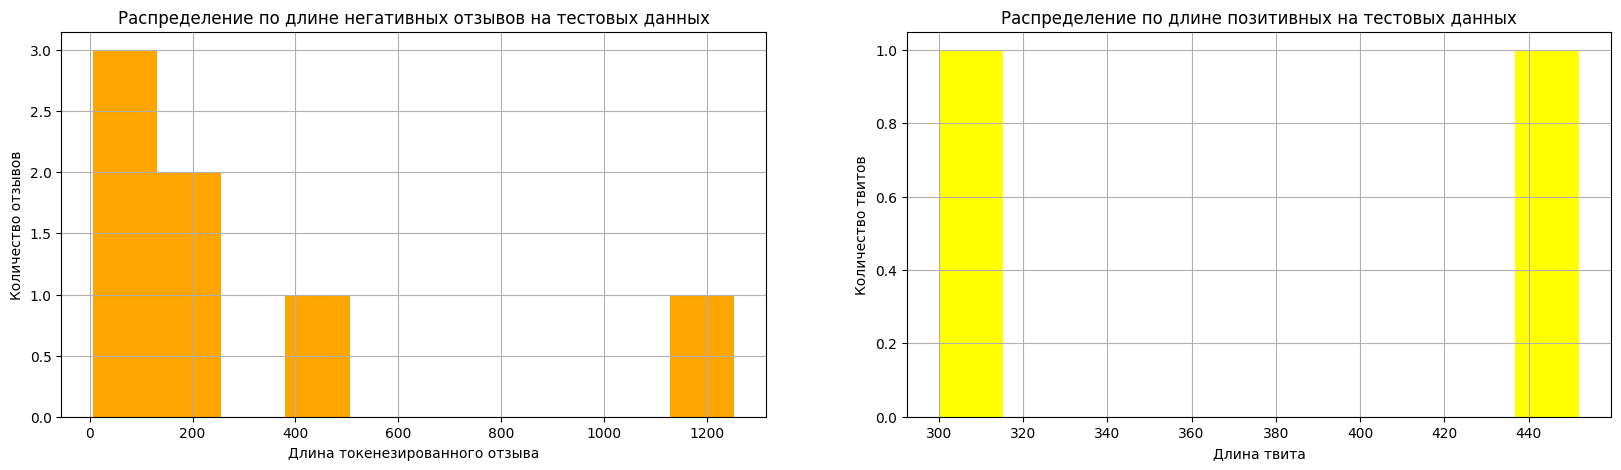

In [10]:
len_negatives = X_test[y_test == 1].str.len()
len_positives = X_test[y_test == 0].str.len()

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(len_negatives,color='orange')
plt.grid()
plt.title('Распределение по длине негативных отзывов на тестовых данных')
plt.xlabel('Длина токенезированного отзыва')
plt.ylabel('Количество отзывов')
plt.subplot(1,2,2)
plt.hist(len_positives,color='yellow',)
plt.grid()
plt.title('Распределение по длине позитивных на тестовых данных')
plt.xlabel('Длина твита')
plt.ylabel('Количество твитов')

## Векторизация

In [11]:
vectorizer = TfidfVectorizer()

In [12]:
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [13]:
vectorizer.get_feature_names_out()

array(['ahead', 'aid', 'air', ..., 'яндекс', 'яркий', 'яркость'],
      dtype=object)

In [14]:
len(vectorizer.get_feature_names_out())

1519

## Обучение модели логистической регрессии

In [15]:
clf_lr = LogisticRegression(random_state = 20)
clf_lr.fit(X_train_vect, y_train)

LogisticRegression(random_state=20)

In [16]:
y_pred_lr = clf_lr.predict(X_test_vect)

### Метрики при логистической регрессии

In [17]:
print("F-мера:", f1_score(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

F-мера: 0.8750000000000001
Accuracy: 0.7777777777777778


## Обучение модели RandomForest с тюнингом параметров

In [18]:
clf_rf = RandomForestClassifier(criterion='entropy')
# params = {"n_estimators": range(100, 1001, 100), "max_depth": range(50, 1001, 50), 
#           "criterion": ["gini", "entropy", "log_loss"]}
# grid_search = GridSearchCV(estimator=clf_rf, param_grid=params, cv=5)
# grid_search.fit(X_train_vect, y_train)
clf_rf.fit(X_train_vect, y_train)

RandomForestClassifier(criterion='entropy')

In [21]:
y_pred_rf = clf_rf.predict(X_test_vect)

In [22]:
print("F-мера:", f1_score(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

F-мера: 0.8750000000000001
Accuracy: 0.7777777777777778


## Сохраняем нужные объекты

In [25]:
with open('../objects/model.pickle', 'wb') as f:
    pickle.dump(clf_lr, f)
    
with open('../objects/vectorizer.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)
    
with open('../objects/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)